# Dogbreed  classifier

*   authors: 


---


-  Jafet Israel Sierra Lagos
-  

---


*   contact: 
-  jafet.sierra.l@gmail.com
-  jccolmenaress@unal.edu.co






In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 10 01:43:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#First conect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/Proyectos/DogBreed/train.zip'

## Libraries

In [4]:
! pip install keras-tuner -q

     |████████████████████████████████| 133 kB 4.1 MB/s 


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Image Data loader

With the image_dataset_from_directory we create a td.dataset object to iterate over the whole dataset. This allows us to maintain the RAM use as low as possible. 

In [6]:
IMG_SIZE = (225,225)
def get_imageDataset(directory,subset=None,batch_size=32,seed=123,shuffle=None):
  return image_dataset_from_directory(
      directory,
      image_size=IMG_SIZE,
      batch_size=batch_size,
      shuffle=shuffle,
      labels='inferred',
      label_mode='categorical',
      seed=seed,
      validation_split=0.15,
      subset=subset
  )

Here we create a train and validation subset

In [7]:
train_ds = get_imageDataset('/content/train',subset='training',shuffle=True)
val_ds   = get_imageDataset('/content/train',subset='validation',shuffle=True)

Found 10222 files belonging to 120 classes.
Using 8689 files for training.
Found 10222 files belonging to 120 classes.
Using 1533 files for validation.


Total number of classes and a new list containing them

In [8]:
class_names = train_ds.class_names
num_class   = len(class_names)
print(class_names)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

Some samples iamges from the train dataset using the method "take()"

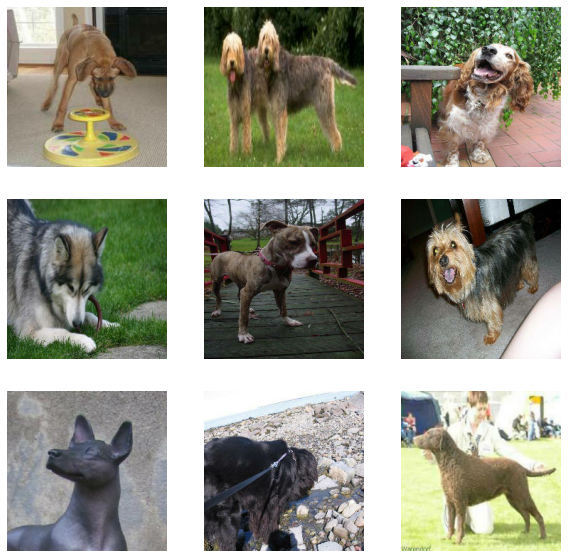

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

we take a look at the image and label shapes.

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 225, 225, 3)
(32, 120)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

#### rotation, flip and zoom

In [21]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
data_aug = Sequential([
    #RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

## Transfer learning model

### ResNet50v2 preprocess

We import and use the preprocees_input that was used in the training of ResNet50V2 model as a new Keras layer

In [57]:
preprocess_layer = preprocess_input

### Base model

ResNet50v2 model trained with Imagenet dataset without the top layers.

In [58]:
IMG_SHAPE = IMG_SIZE+(3,)
base_model = ResNet50V2(
  input_shape=(IMG_SHAPE),
  include_top=False,
  weights='imagenet'
)

Freeze the layers of the base model

In [59]:
base_model.trainable = False

In [ ]:
base_model.summary()

### Basemodel + Classification head using keras_tuner for choosing the right architecture

Here we declare the head for the base model, consisting of a **Dense** layer with a total of **2048 neurons**, and an output layer with a "**num_classes**" value as the number of neurons. **Dropout** and **l2** were used as regularizers. 

In [61]:
'''
inputs = Input(shape=(224,224,3))
x = data_aug(inputs)
x = preprocess_layer(x)
x = base_model(x,training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(2048,activation='relu',kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
out = Dense(num_class,activation='softmax')(x)

model = Model(inputs=inputs,outputs=out)

metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

model.compile(
    optimizer=Adam(5e-3),
    loss='categorical_crossentropy',
    metrics=metricas
)
model.summary()
'''
def build_model(hp):  
  inputs = Input(shape=(224,224,3))
  x = data_aug(inputs)
  x = preprocess_layer(x)
  x = base_model(x,training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  for i in range(hp.Int("num_dense_layers",1,3)):
    x = Dense(
            units=hp.Int(f"units_{i}",min_value=64,max_value=512,step=64),
            activation='relu',
            kernel_regularizer='l2'
        )(x)
    x = Dropout(hp.Float(f"dpr_{i}",min_value=0.1,max_value=0.4,step=0.1))(x)
  out = Dense(num_class,activation='softmax')(x)


  learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")

  model = Model(inputs=inputs,outputs=out)

  metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

  model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=metricas
  )

  return model

In [62]:
def scheduler(epoch,lr):
  if epoch<5:
    return lr
  else:
    return lr*tf.math.exp(-0.105)

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_categorical_accuracy",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="/content/keras_tuner",
    project_name="mnist_keras_tuner"
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
dpr_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [63]:
tuner.search(train_ds, epochs=3, validation_data=val_ds,callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])

Trial 20 Complete [00h 02m 14s]
val_categorical_accuracy: 0.6399217247962952

Best val_categorical_accuracy So Far: 0.7361382842063904
Total elapsed time: 00h 44m 18s
INFO:tensorflow:Oracle triggered exit


In [64]:
models = tuner.get_best_models(num_models=3)
best_model = models[0]

In [ ]:
tuner.results_summary()

In [66]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])

In [67]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

We define a scheduler and a checkpoint custom functions as callbacks

The model is trained for 20 epochs using the datagenerators created previously. 

In [68]:
def scheduler(epoch,lr):
  if epoch<10:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp


history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=20,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best()],
      verbose=1
)

Epoch 1/20
271/272 [============================>.] - ETA: 0s - loss: 8.4950 - categorical_accuracy: 0.2191 - precision_1: 0.6529 - recall_1: 0.0549
Epoch 1: val_categorical_accuracy improved from -inf to 0.65884, saving model to checkpoint_best/checkpoint
272/272 [==============================] - 25s 75ms/step - loss: 8.4896 - categorical_accuracy: 0.2196 - precision_1: 0.6517 - recall_1: 0.0551 - val_loss: 5.1086 - val_categorical_accuracy: 0.6588 - val_precision_1: 0.8701 - val_recall_1: 0.3451 - lr: 2.6186e-04
Epoch 2/20
271/272 [============================>.] - ETA: 0s - loss: 5.2214 - categorical_accuracy: 0.4400 - precision_1: 0.7018 - recall_1: 0.2546
Epoch 2: val_categorical_accuracy improved from 0.65884 to 0.71950, saving model to checkpoint_best/checkpoint
272/272 [==============================] - 19s 70ms/step - loss: 5.2197 - categorical_accuracy: 0.4404 - precision_1: 0.7024 - recall_1: 0.2548 - val_loss: 3.6289 - val_categorical_accuracy: 0.7195 - val_precision_1: 0.

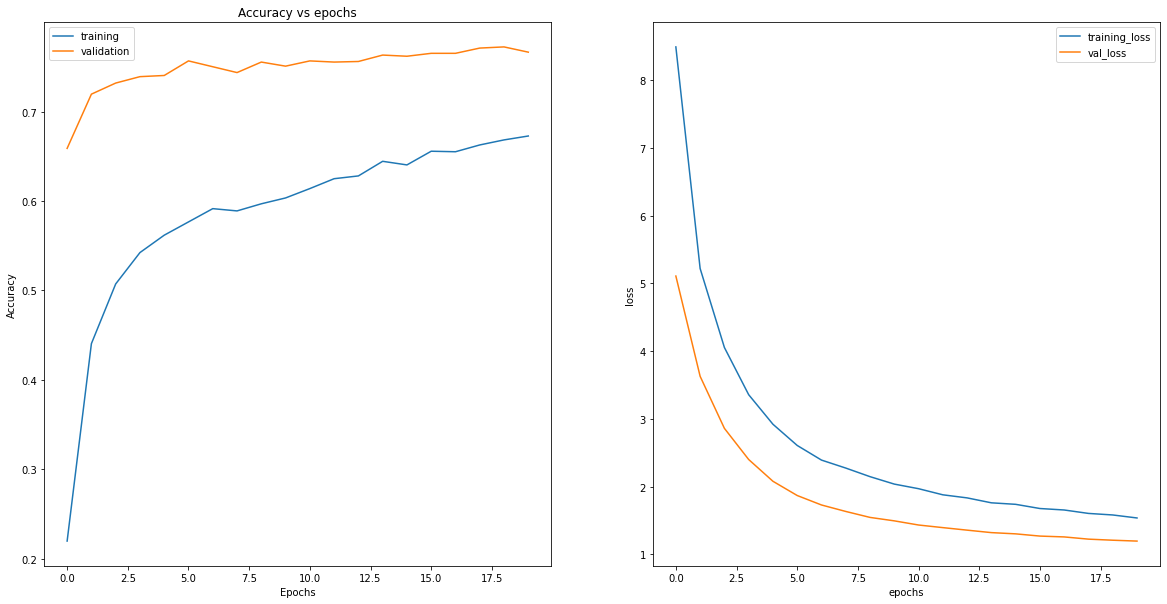

In [69]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20,10))
plt.subplot(121)
try:
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
except KeyError:
  plt.plot(history.history['acc_categorical_'])
  plt.plot(history.history['val_categorical_acc'])
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()

### fine tuning

Unfreez the base model layers.

In [70]:
base_model.trainable = True

In [73]:
print("Number of layers  ", len(base_model.layers))

Number of layers   190


Freeze all the layers before the `fine_tune_at` layer

In [74]:
fine_tune_at = 180

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Same metrics functions as before

In [75]:
metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

model.compile(
    optimizer=Adam(2e-5),
    loss='categorical_crossentropy',
    metrics=metricas
)

In [76]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

Re train the model with a few unfreezed layers. 

In [77]:
def checkpoint_best_ft():
  path = 'checkpoint_best_ft/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
def fine_scheduler(epoch,lr):
  if epoch<1:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

ini_epochs = len(history.epoch)
fine_tun_epochs = 10
total_epochs = ini_epochs + fine_tun_epochs

history_fine = model.fit(
      train_ds,
      validation_data=val_ds,
      initial_epoch=history.epoch[-1],
      epochs=total_epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(fine_scheduler),checkpoint_best_ft()],
      verbose=1
)

Epoch 20/30
271/272 [============================>.] - ETA: 0s - loss: 1.4772 - categorical_accuracy: 0.6825 - precision_2: 0.8217 - recall_2: 0.5558
Epoch 20: val_categorical_accuracy improved from -inf to 0.76451, saving model to checkpoint_best_ft/checkpoint
272/272 [==============================] - 26s 80ms/step - loss: 1.4768 - categorical_accuracy: 0.6826 - precision_2: 0.8217 - recall_2: 0.5560 - val_loss: 1.1845 - val_categorical_accuracy: 0.7645 - val_precision_2: 0.8443 - val_recall_2: 0.6967 - lr: 1.8097e-05
Epoch 21/30
271/272 [============================>.] - ETA: 0s - loss: 1.4238 - categorical_accuracy: 0.6966 - precision_2: 0.8315 - recall_2: 0.5788
Epoch 21: val_categorical_accuracy improved from 0.76451 to 0.77038, saving model to checkpoint_best_ft/checkpoint
272/272 [==============================] - 20s 75ms/step - loss: 1.4227 - categorical_accuracy: 0.6971 - precision_2: 0.8317 - recall_2: 0.5791 - val_loss: 1.1713 - val_categorical_accuracy: 0.7704 - val_preci

In [78]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

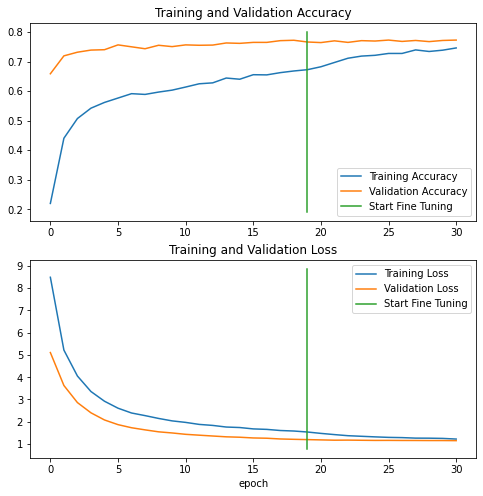

In [79]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([ini_epochs-1,ini_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([ini_epochs-1,ini_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Custom model

Here we declare the head for the base model, consisting of a **Dense** layer with a total of **2048 neurons**, and an output layer with a "**num_classes**" value as the number of neurons. **Dropout** and **l2** were used as regularizers. 

In [23]:
def build_model(hp):  
  inputs = Input(shape=(225,225,3))
  x = data_aug(inputs)
  for i in range(hp.Int("num_conv_blocks",1,4)):
    x = Conv2D(hp.Int(f"num_filters_{i}",min_value=5,max_value=20,step=5),hp.Int(f"kernel_size_{i}",min_value=2,max_value=6,step=2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D()(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  for i in range(hp.Int("num_dense_layers",1,3)):
    x = Dense(
            units=hp.Int(f"units_{i}",min_value=128,max_value=256,step=128),
            activation='relu',
            kernel_regularizer='l2'
        )(x)
    x = Dropout(hp.Float(f"dpr_{i}",min_value=0.2,max_value=0.4,step=0.1))(x)
  out = Dense(num_class,activation='softmax')(x)


  learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")

  model = Model(inputs=inputs,outputs=out)

  metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

  model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=metricas
  )

  return model

In [24]:
def scheduler(epoch,lr):
  if epoch<5:
    return lr
  else:
    return lr*tf.math.exp(-0.105)

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_categorical_accuracy",
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory="/content/keras_tuner",
    project_name="dogBreed_keras_tuner"
)
tuner.search_space_summary()

Search space summary
Default search space size: 7
num_conv_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
num_filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 5, 'sampling': None}
kernel_size_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 2, 'sampling': None}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
dpr_0 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [25]:
tuner.search(train_ds, epochs=2, validation_data=val_ds,callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])

Trial 50 Complete [00h 00m 47s]
val_categorical_accuracy: 0.008806261932477355

Best val_categorical_accuracy So Far: 0.019243312999606133
Total elapsed time: 00h 37m 46s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

In [26]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 225, 225, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 20)      980       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 20)     80        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 222, 222, 20)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 20)     0         
 2D)                                                       

We define a scheduler and a checkpoint custom functions as callbacks

The model is trained for 20 epochs using the datagenerators created previously. 

In [28]:
def scheduler(epoch,lr):
  if epoch<10:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp


history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=20,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best()],
      verbose=1
)

Epoch 1/20
272/272 [==============================] - ETA: 0s - loss: 4.9155 - categorical_accuracy: 0.0145 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 1: val_categorical_accuracy improved from -inf to 0.01631, saving model to checkpoint_best/checkpoint
272/272 [==============================] - 13s 42ms/step - loss: 4.9155 - categorical_accuracy: 0.0145 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 4.8277 - val_categorical_accuracy: 0.0163 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 8.8234e-04
Epoch 2/20
271/272 [============================>.] - ETA: 0s - loss: 4.7048 - categorical_accuracy: 0.0262 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: val_categorical_accuracy did not improve from 0.01631
272/272 [==============================] - 11s 40ms/step - loss: 4.7045 - categorical_accuracy: 0.0262 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 4.7891 - val_categorical_accuracy: 0.0150 - val_precision_1: 0.0000e+00

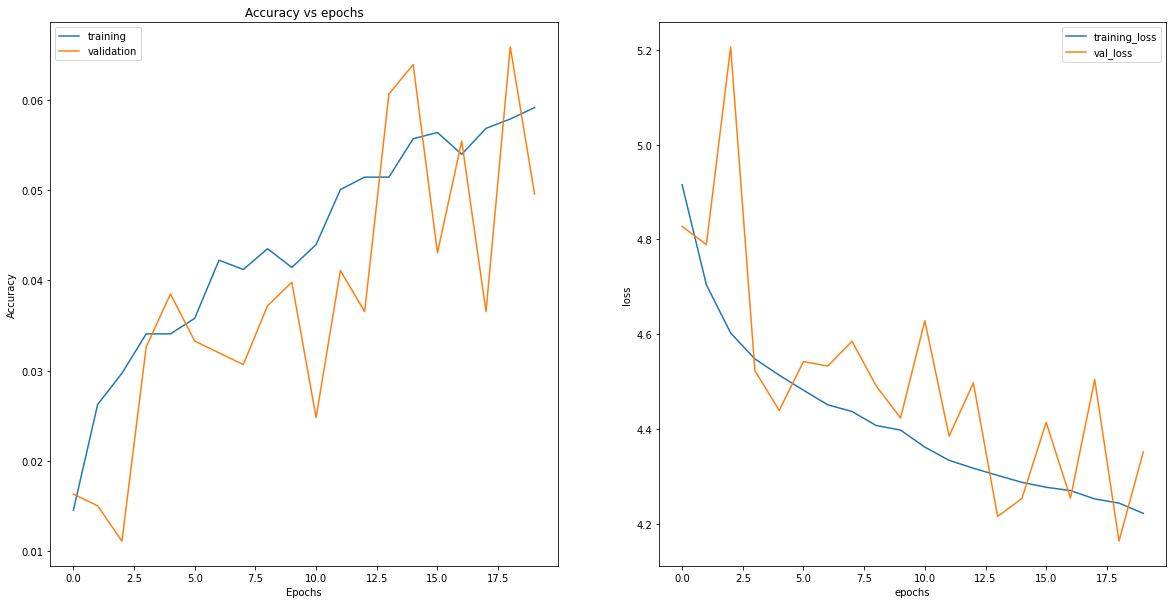

In [29]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20,10))
plt.subplot(121)
try:
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
except KeyError:
  plt.plot(history.history['acc_categorical_'])
  plt.plot(history.history['val_categorical_acc'])
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()

### fine tuning

Unfreez the base model layers.

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers  ", len(base_model.layers))

Number of layers   190


Freeze all the layers before the `fine_tune_at` layer

In [ ]:
fine_tune_at = 180

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Same metrics functions as before

In [ ]:
metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

model.compile(
    optimizer=Adam(2e-5),
    loss='categorical_crossentropy',
    metrics=metricas
)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

Re train the model with a few unfreezed layers. 

In [ ]:
def checkpoint_best_ft():
  path = 'checkpoint_best_ft/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
def fine_scheduler(epoch,lr):
  if epoch<1:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

ini_epochs = len(history.epoch)
fine_tun_epochs = 10
total_epochs = ini_epochs + fine_tun_epochs

history_fine = model.fit(
      train_ds,
      validation_data=val_ds,
      initial_epoch=history.epoch[-1],
      epochs=total_epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(fine_scheduler),checkpoint_best_ft()],
      verbose=1
)

Epoch 20/30
271/272 [============================>.] - ETA: 0s - loss: 1.4772 - categorical_accuracy: 0.6825 - precision_2: 0.8217 - recall_2: 0.5558
Epoch 20: val_categorical_accuracy improved from -inf to 0.76451, saving model to checkpoint_best_ft/checkpoint
272/272 [==============================] - 26s 80ms/step - loss: 1.4768 - categorical_accuracy: 0.6826 - precision_2: 0.8217 - recall_2: 0.5560 - val_loss: 1.1845 - val_categorical_accuracy: 0.7645 - val_precision_2: 0.8443 - val_recall_2: 0.6967 - lr: 1.8097e-05
Epoch 21/30
271/272 [============================>.] - ETA: 0s - loss: 1.4238 - categorical_accuracy: 0.6966 - precision_2: 0.8315 - recall_2: 0.5788
Epoch 21: val_categorical_accuracy improved from 0.76451 to 0.77038, saving model to checkpoint_best_ft/checkpoint
272/272 [==============================] - 20s 75ms/step - loss: 1.4227 - categorical_accuracy: 0.6971 - precision_2: 0.8317 - recall_2: 0.5791 - val_loss: 1.1713 - val_categorical_accuracy: 0.7704 - val_preci

In [ ]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

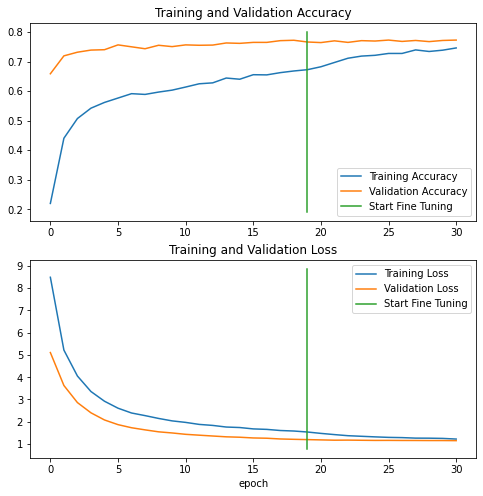

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([ini_epochs-1,ini_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([ini_epochs-1,ini_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()